<h1><center>Transcriptomic Differences Contributing to Morphological and Electrophysiological Distinctions Between Excitatory and Inhibitory Cell Types</center></h1>

## Cell Type Group 9
## Team Member Names & Contributions:

- **Kyle Okamuro** (A13776497): worked on the writing and coding aspects of the project.
- **Bijou DeJong** (A13890147): worked on the coding and formatting of the Jupyter notebook.
- **Bryce Corley** (A14381746): worked on the writing aspects of the project and formatting of the Jupyter notebook. 

# I. Introduction & Background:

## Overview/Abstract:

Add Abstract

## Research Question:

What intrinsic electrophysiological and morphological differences exist between excitatory and inhibitory cell types and what are the transcriptomic differences contributing to these phenotypic differences?

## Background & Prior Work:

&emsp; Add background

## References:

add references

## Hypothesis:

We hypothesize that

# II. Data Analysis:

## Setup:
Import and download the following packages and datasets in order to get started with the project!

In [5]:
#Import the "Cell Types Cache" from the AllenSDK core package.
from allensdk.core.cell_types_cache import CellTypesCache

#Import CellTypesApi, which will allow us to query the database.
from allensdk.api.queries.cell_types_api import CellTypesApi

#Initialize cache as 'ctc' (cell types cache).
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

#Import tool used to get AP spike data for specimen.
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

#Get rid of all the ugly red warnings.
import warnings
warnings.filterwarnings('ignore')

#Import Pandas and Numpy for manipulating and analyzing data.
import pandas as pd
import numpy as np

#Import Scipy and Matplot for statistics and plotting purposes.
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Wrangling:

Prestigio, the paper we are primarily basing our project off of, used mouse data. So, filter the cells data to only get the mouse specimen.

In [6]:
mouse_cells_df = pd.DataFrame(ctc.get_cells(species = ['mus musculus']))
mouse_ids_df = mouse_cells_df[['id','dendrite_type']].set_index('id')
print('num specimen: ' + str(mouse_ids_df.shape[0]))
mouse_ids_df.head()

num specimen: 1920


,dendrite_type
id,
565871768,aspiny
469801138,aspiny
605889373,aspiny
485909730,spiny
323865917,spiny


Next, get the ID numbers of all mouse specimen with electrophysiology features. Include the rheobase sweep number for a later step.

In [7]:
ephys_features_df = pd.DataFrame(ctc.get_ephys_features())
ephys_ids_df = ephys_features_df[['specimen_id','rheobase_sweep_number']].set_index('specimen_id')
print('num specimen: ' + str(ephys_ids_df.shape[0]))
ephys_ids_df.head()

num specimen: 2333


,rheobase_sweep_number
specimen_id,
529878215,78
548459652,55
579978640,38
439024551,41
515188639,36


Use the inner join function to get specimen ID numbers of mice that have electrophysiology data.

Assuming that 'id' in the mouse cells dataframe is the same as 'specimen id' in the electrophysiology data, we can get the rheobase sweep number for each mouse specimen.

In [8]:
me_rheobase_df = mouse_ids_df.join(ephys_ids_df).reset_index()

# renaming the column here makes it easier to merge/join dataframes later
me_rheobase_df = me_rheobase_df.rename(columns={"id": "specimen_id"})

# this df has mouse ephys rheobase data
print('num specimen: ' + str(me_rheobase_df.shape[0]))
me_rheobase_df.head()

num specimen: 1920


,specimen_id,dendrite_type,rheobase_sweep_number
0,565871768,aspiny,40
1,469801138,aspiny,57
2,605889373,aspiny,53
3,485909730,spiny,33
4,323865917,spiny,34


Next, get the morphology dataset.

In [9]:
morph_feats_df = pd.DataFrame(ctc.get_morphology_features())
print('num specimen: ' + str(morph_feats_df.shape[0]))

num specimen: 671


Now we can use the morphology dataset to select for specimen that are mice, have electrophysiology data, and have morphology data by performing an inner merge of the two datasets. After performing the inner merge, get the id's from this merged dataset and make a morphology dataframe of those id's, as well as make an electrophysiology dataframe.

In [10]:
ephys_morph_mice_df = me_rheobase_df.merge(morph_feats_df,on='specimen_id', how='inner')

# this contains the ids of the mice with ephys and morph data
df_ids = ephys_morph_mice_df[['specimen_id']]

# make ephys df of only the mice with morphology and ephys data
ephys_df = ephys_features_df.merge(df_ids, on='specimen_id', how='inner')

# make morphology df of only the mice with morphology and ephys data
morph_df = morph_feats_df.merge(df_ids, on='specimen_id', how='inner')

Create a helper method to classify each specimen as inhibitory or excitatory by accessing their dendrite type in the `.get_cells()` method.

In [11]:
def classify(specimen_id):
    '''classifies a specimen as inhibitory or excitatory based on if its spiny or aspiny'''
    a_or_s = mouse_ids_df.loc[specimen_id]['dendrite_type']
    
    if a_or_s == 'spiny':
        return 'excitatory'
    else:
        return 'inhibitory'

Next, add a column to specify whether the neurons were inhibitory or excitatory to the electrophysiology and morphology data.

In [12]:
ephys_df['inhib/excit'] = ephys_df['specimen_id'].apply(classify)
ephys_df.head()

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,1.806510,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,1.298640,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,1.054124,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,1.631545,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,1.188280,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory


In [13]:
morph_df['inhib/excit'] = morph_df['specimen_id'].apply(classify)
morph_df = morph_df.set_index('specimen_id')
print('num specimen: ' + str(morph_df.shape[0]))
morph_df.head()

num specimen: 519


,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id,max_branch_order,max_euclidean_distance,...,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume,inhib/excit
specimen_id,,,,,,,,,,,,,,,,,,,,,
478107198,82.727781,NaN,0.864267,0.345092,20.723077,0.964510,NaN,491119743,6.0,99.779724,...,0.1144,0.1144,0.28,435.740270,False,3D Neuron Reconstruction morphology,1666.082926,1803.875644,167.343086,inhibitory
502367941,82.506680,NaN,0.903890,0.634047,105.277778,0.862183,NaN,546781359,3.0,432.383110,...,0.1144,0.1144,0.28,1446.587725,False,3D Neuron Reconstruction morphology,2277.259374,4543.139073,921.571895,excitatory
515771244,77.536678,NaN,0.863104,0.417929,73.666667,0.926633,NaN,537042261,6.0,373.630444,...,0.1144,0.1144,0.28,287.118123,False,3D Neuron Reconstruction morphology,3589.339062,4704.910407,582.285423,excitatory
591268268,72.019250,NaN,0.873518,0.227626,47.535714,1.000000,NaN,657879305,5.0,186.218009,...,0.1144,0.1144,0.28,55.055236,False,3D Neuron Reconstruction morphology,1659.465869,1185.773462,69.144146,inhibitory
469753383,68.459909,NaN,0.889767,0.259649,28.263158,1.085194,NaN,491120305,6.0,107.897533,...,0.1144,0.1144,0.28,358.755159,False,3D Neuron Reconstruction morphology,1825.646321,1499.858295,108.114604,inhibitory


Next, get rid of all of the columns that are not quantitative, with the exception of the inhibitory/excitatory column.

In [14]:
#Drop columns that are not quantitative, with the exception of the inhib/excit columns
morph_df = morph_df.drop(columns=['superseded','tags','neuron_reconstruction_type'])

In [15]:
#Check for null values
morph_df.isnull().sum()

average_bifurcation_angle_local       0
average_bifurcation_angle_remote    519
average_contraction                   0
average_diameter                      0
average_fragmentation                 0
average_parent_daughter_ratio         0
hausdorff_dimension                 519
id                                    0
max_branch_order                      0
max_euclidean_distance                0
max_path_distance                     0
number_bifurcations                   0
number_branches                       0
number_nodes                          0
number_stems                          0
number_tips                           0
overall_depth                         0
overall_height                        0
overall_width                         0
scale_factor_x                        0
scale_factor_y                        0
scale_factor_z                        0
soma_surface                          0
total_length                          0
total_surface                         0


`morph_df` has nan for all of its values in 'hausdorff_dimension' and 'average_bifurcation_angle_remote', so get rid of those columns to simplify the code.

In [16]:
#Do not include columns in morph_df that are unrelated to morphology (ie. id numbers)
morph_columns = list(morph_df.columns)
morph_columns.remove('id')
morph_columns.remove('average_bifurcation_angle_remote')
morph_columns.remove('hausdorff_dimension')
morph_columns.remove('inhib/excit')
morph_columns

['average_bifurcation_angle_local',
 'average_contraction',
 'average_diameter',
 'average_fragmentation',
 'average_parent_daughter_ratio',
 'max_branch_order',
 'max_euclidean_distance',
 'max_path_distance',
 'number_bifurcations',
 'number_branches',
 'number_nodes',
 'number_stems',
 'number_tips',
 'overall_depth',
 'overall_height',
 'overall_width',
 'scale_factor_x',
 'scale_factor_y',
 'scale_factor_z',
 'soma_surface',
 'total_length',
 'total_surface',
 'total_volume']

In [17]:
inhib_morph_df = morph_df[morph_df['inhib/excit'] == 'inhibitory'].drop(columns = ['inhib/excit'])
excit_morph_df = morph_df[morph_df['inhib/excit'] == 'excitatory'].drop(columns = ['inhib/excit'])
print("inhib df shape:" + str(inhib_morph_df.shape))
print("excit df shape:" + str(excit_morph_df.shape))

inhib df shape:(279, 26)
excit df shape:(240, 26)


### AP Half Width Calculation:
The next step of the code will be to calculate AP half width by accessing a specimen's rheobase sweep data through it's rheobase sweep number.

First, set the index in order to use the .loc method

In [18]:
#Setting the index here allows us to use the .loc method in helper function
rheobase_df = me_rheobase_df.set_index('specimen_id')
rheobase_df

,dendrite_type,rheobase_sweep_number
specimen_id,,
565871768,aspiny,40
469801138,aspiny,57
605889373,aspiny,53
485909730,spiny,33
323865917,spiny,34
...,...,...
512322162,spiny,44
488473535,aspiny,57
467003163,spiny,45


Next, use a helper function to calculate spike width.
In order to calculate the spike width, we used the the following code which comes from the following link: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html#Computing-Electrophysiology-Features

In [19]:
def calc_spike_width(specimen_id):
    ''' calculates the spike width using specimen id to get the data. returns 0.0 if file does not exist'''
    try:
        data_set = ctc.get_ephys_data(specimen_id)
        sweep_number = rheobase_df.loc[specimen_id]['rheobase_sweep_number']
        sweep_data = data_set.get_sweep(sweep_number)

        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        i *= 1e12 # to pA
        v *= 1e3 # to mV

        sampling_rate = sweep_data["sampling_rate"] # in Hz
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
        sweep_ext.process_spikes()

        return round(1e3 * np.nanmean(sweep_ext.spike_feature("width")),4)
    
    except OSError as e:
        return -100

Calculating the AP half width for the whole dataframe at this point takes an excessively long time due to the method since some of the iterations require their own download. For this reason, it is recommended to take a sample of the first 30 specimen and calculate their spike widths (AP half widths).

In [20]:
ephys40 = ephys_df.head(30)

In [21]:
ephys40['spike_width'] = ephys40['specimen_id'].apply(calc_spike_width)
ephys40

2020-03-13 12:39:13,353 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/501271464
2020-03-13 12:39:25,797 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657593433
2020-03-13 12:39:36,385 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491202203
2020-03-13 12:39:51,994 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657593525
2020-03-13 12:40:02,710 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/515347281
2020-03-13 12:40:11,397 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/539899473
2020-03-13 12:40:23,599 allensdk.api.api.retrieve_fi

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit,spike_width
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory,0.9183
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory,0.3753
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory,1.0400
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory,0.9100
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory,0.8800
5,NaN,58.600000,-36.739996,0.095076,1.101680,11.133833,1.025875,-48.125004,-47.135418,-56.742191,...,-48.312504,-49.520835,-80.875006,2.121035,1.797871,2.397005,-93.906250,-80.402931,excitatory,0.9800
6,0.410374,24.886667,2.337500,0.053163,1.199040,11.020927,1.024433,-54.593754,-50.635418,-56.750004,...,-57.187500,-50.791668,-70.156255,1.783955,1.581153,1.861108,-100.375008,-69.816109,inhibitory,0.4800
7,0.176194,12.770000,-29.125001,0.828687,1.045960,9.596560,1.024035,-52.281254,-48.031252,-57.105471,...,-52.468754,-48.828127,-76.550787,1.566557,1.510595,1.713518,-89.937500,-76.392235,inhibitory,0.4000
8,0.054985,26.074167,-13.989375,0.035491,1.090215,3.391177,1.024271,-45.906254,-42.875003,-52.750002,...,-46.593750,-46.000003,-67.244795,2.347381,2.069299,2.389602,-94.218750,-66.155899,inhibitory,0.4625
9,0.046079,97.000000,23.797500,0.124640,1.156475,6.003742,1.025527,-42.000004,-42.354168,-46.335939,...,-52.562500,-53.708337,-72.765629,3.119665,3.083533,3.068449,-85.968758,-72.388512,excitatory,0.8217


Since our helper method returned '-100' every time the file required to calculate spike width was not found, we drop the rows with -100.

In [22]:
ephys40 = ephys40[ephys40['spike_width'] != -100]
ephys40

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit,spike_width
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory,0.9183
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory,0.3753
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory,1.0400
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory,0.9100
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory,0.8800
5,NaN,58.600000,-36.739996,0.095076,1.101680,11.133833,1.025875,-48.125004,-47.135418,-56.742191,...,-48.312504,-49.520835,-80.875006,2.121035,1.797871,2.397005,-93.906250,-80.402931,excitatory,0.9800
6,0.410374,24.886667,2.337500,0.053163,1.199040,11.020927,1.024433,-54.593754,-50.635418,-56.750004,...,-57.187500,-50.791668,-70.156255,1.783955,1.581153,1.861108,-100.375008,-69.816109,inhibitory,0.4800
7,0.176194,12.770000,-29.125001,0.828687,1.045960,9.596560,1.024035,-52.281254,-48.031252,-57.105471,...,-52.468754,-48.828127,-76.550787,1.566557,1.510595,1.713518,-89.937500,-76.392235,inhibitory,0.4000
8,0.054985,26.074167,-13.989375,0.035491,1.090215,3.391177,1.024271,-45.906254,-42.875003,-52.750002,...,-46.593750,-46.000003,-67.244795,2.347381,2.069299,2.389602,-94.218750,-66.155899,inhibitory,0.4625
9,0.046079,97.000000,23.797500,0.124640,1.156475,6.003742,1.025527,-42.000004,-42.354168,-46.335939,...,-52.562500,-53.708337,-72.765629,3.119665,3.083533,3.068449,-85.968758,-72.388512,excitatory,0.8217


### Electrophysiology Data:

After calculating AP Half Width, let's move on to cleaning and simplifying the electrophysiology data

In [23]:
#check to make sure there's no columns with all NaN values (like we saw in the morphology data)
ephys40.isnull().sum().sort_values(ascending=False)

slow_trough_v_short_square                10
slow_trough_t_short_square                10
slow_trough_t_long_square                  9
slow_trough_v_long_square                  9
slow_trough_t_ramp                         7
slow_trough_v_ramp                         7
adaptation                                 2
avg_isi                                    1
trough_v_short_square                      0
has_pause                                  0
rheobase_sweep_id                          0
peak_v_short_square                        0
peak_v_ramp                                0
peak_v_long_square                         0
peak_t_short_square                        0
peak_t_ramp                                0
peak_t_long_square                         0
latency                                    0
input_resistance_mohm                      0
id                                         0
has_delay                                  0
ri                                         0
has_burst 

In [24]:
#This line of code checks the type of each value in each column:
ephys40.dtypes

adaptation                                float64
avg_isi                                   float64
electrode_0_pa                            float64
f_i_curve_slope                           float64
fast_trough_t_long_square                 float64
fast_trough_t_ramp                        float64
fast_trough_t_short_square                float64
fast_trough_v_long_square                 float64
fast_trough_v_ramp                        float64
fast_trough_v_short_square                float64
has_burst                                    bool
has_delay                                    bool
has_pause                                    bool
id                                          int64
input_resistance_mohm                     float64
latency                                   float64
peak_t_long_square                        float64
peak_t_ramp                               float64
peak_t_short_square                       float64
peak_v_long_square                        float64


In [25]:
ephys_columns = list(ephys40.columns)

#Now, let's get rid of all the features that involve the stimulus since 
#they are unrelated to the intrinsic properties of the neuron

cleaned_columns = []

for word in ephys_columns:
    if 'square' in word:
        print(word)
    elif 'ramp' in word:
        print(word)
    else:
        cleaned_columns.append(word)

#Next, create a list of columns to omit
invalids = ['has_burst','has_delay','has_pause','inhib/excit','id', 'rheobase_sweep_id','specimen_id',\
            'thumbnail_sweep_id']

for i in invalids:
    cleaned_columns.remove(i)
        
cleaned_columns

fast_trough_t_long_square
fast_trough_t_ramp
fast_trough_t_short_square
fast_trough_v_long_square
fast_trough_v_ramp
fast_trough_v_short_square
peak_t_long_square
peak_t_ramp
peak_t_short_square
peak_v_long_square
peak_v_ramp
peak_v_short_square
slow_trough_t_long_square
slow_trough_t_ramp
slow_trough_t_short_square
slow_trough_v_long_square
slow_trough_v_ramp
slow_trough_v_short_square
threshold_i_long_square
threshold_i_ramp
threshold_i_short_square
threshold_t_long_square
threshold_t_ramp
threshold_t_short_square
threshold_v_long_square
threshold_v_ramp
threshold_v_short_square
trough_t_long_square
trough_t_ramp
trough_t_short_square
trough_v_long_square
trough_v_ramp
trough_v_short_square
upstroke_downstroke_ratio_long_square
upstroke_downstroke_ratio_ramp
upstroke_downstroke_ratio_short_square


['adaptation',
 'avg_isi',
 'electrode_0_pa',
 'f_i_curve_slope',
 'input_resistance_mohm',
 'latency',
 'rheobase_sweep_number',
 'ri',
 'sag',
 'seal_gohm',
 'tau',
 'vm_for_sag',
 'vrest',
 'spike_width']

In [26]:
inhib_ephys_df = ephys40[ephys40['inhib/excit'] == 'inhibitory'].drop(columns = ['inhib/excit'])
excit_ephys_df = ephys40[ephys40['inhib/excit'] == 'excitatory'].drop(columns = ['inhib/excit'])

print("inhib df shape:" + str(inhib_ephys_df.shape))
print("excit df shape:" + str(excit_ephys_df.shape))

inhib df shape:(13, 57)
excit df shape:(17, 57)


## Data Visualization:

## Data Analysis & Results:

### Electrophysiology:

Since we subtract excitatory from inhibitory means, a positive zscore indicates that the excitatory mean value is higher than the inhibitory mean value.

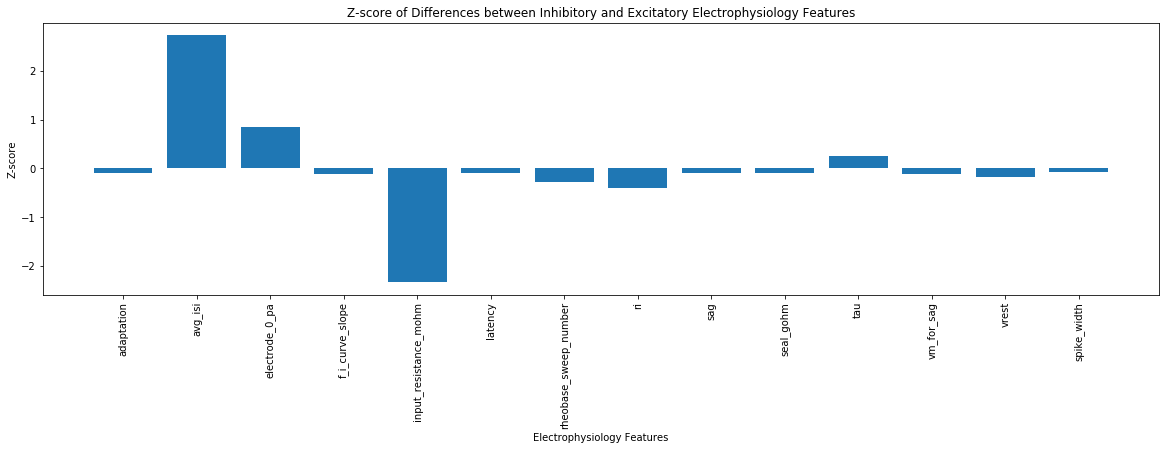

In [27]:
# Set up the figure
fig,ax = plt.subplots(figsize=(20,5))

differences = []

for i in cleaned_columns:
    inhib_mean = np.mean(inhib_ephys_df[i])
    excit_mean = np.mean(excit_ephys_df[i])
    differences.append(excit_mean - inhib_mean)

diff_zscore = stats.zscore(differences)
ax.bar(cleaned_columns, diff_zscore)
plt.xticks(rotation=90)

ax.set_xlabel('Electrophysiology Features')
ax.set_ylabel('Z-score')
ax.set_title("Z-score of Differences between Inhibitory and Excitatory Electrophysiology Features")

plt.show()

In [28]:
significant_indexes = []

for i in diff_zscore:
    if i >= 1.96:
        significant_indexes.append(i)
    elif i <= -1.96:
        significant_indexes.append(i)

# make a dictionary of columns and zscores
ephys_zscore_dict = dict()

for i in range(len(diff_zscore)):
    ephys_zscore_dict[cleaned_columns[i]] = [diff_zscore[i]]

ephys_zscores = pd.DataFrame(ephys_zscore_dict)
ephys_zscores = ephys_zscores[['avg_isi', 'input_resistance_mohm', 'spike_width']]
ephys_zscores

,avg_isi,input_resistance_mohm,spike_width
0,2.729209,-2.331835,-0.071878


After looking through the zscores, we see that 'avg_isi' and 'input_resistance_mohm' are the electrophysiology features that have  a zscore >= 1.96 or <= -1.96, indicating that there is a significant difference (with an alpha value of 0.05). The 'avg_isi' is positive, suggesting that the mean inter-spike-interval of excitatory neurons is significantly greater than that of the inhibitory neurons. Since input resistance is negative, the mean of input resistance of inhibitory neurons is significantly greater than that of the excitatory neurons.

Although spike width does not indicate a significant difference between excitatory and inhibitory neurons (having a zscore value of -0.071878), it is still a relevant piece of data that should be displayed as it relates to our main claim. Refer to the boxplot shown below for further comparisons of excitatory/inhibitory AP Half Width. 

### Morphology:

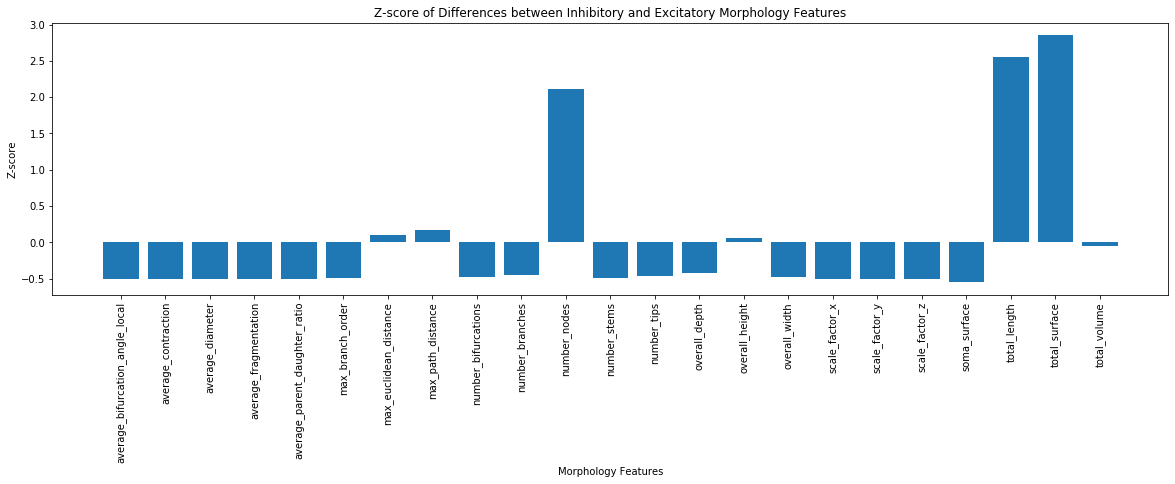

In [29]:
# Set up the figure
fig,ax = plt.subplots(figsize=(20,5))

differences = []

for i in morph_columns:
    inhib_mean = np.mean(inhib_morph_df[i])
    excit_mean = np.mean(excit_morph_df[i])
    differences.append(excit_mean - inhib_mean)

diff_zscore = stats.zscore(differences)
ax.bar(morph_columns, diff_zscore)
plt.xticks(rotation=90)

ax.set_xlabel('Morphology Features')
ax.set_ylabel('Z-score')
ax.set_title("Z-score of Differences between Inhibitory and Excitatory Morphology Features")

plt.show()

In [30]:
significant_indexes = []

for i in diff_zscore:
    if i >= 1.96:
        significant_indexes.append(i)
    elif i <= -1.96:
        significant_indexes.append(i)
        
# make a dictionary of columns and zscores
morph_zscore_dict = dict()

for i in range(len(diff_zscore)):
    morph_zscore_dict[morph_columns[i]] = [diff_zscore[i]]

morph_zscores = pd.DataFrame(morph_zscore_dict)
morph_zscores = morph_zscores[['number_nodes','total_length','total_surface']]
morph_zscores

,number_nodes,total_length,total_surface
0,2.113944,2.554072,2.852513


The zscores for number of nodes, total length, and total surface area are all significant (>= 1.96). They are all positive values, highlighting that excitatory neurons have a greater mean number of nodes, greater total length, and greater total surface area than those of inhibitory neurons.

### Spike Width Comparison via Boxplot:

Finally, let's plot the spike width data for both the inhibitory and excitatory groups.

Text(0.5, 1.0, 'AP Half Width in Inhibitory v Excitatory Neurons')

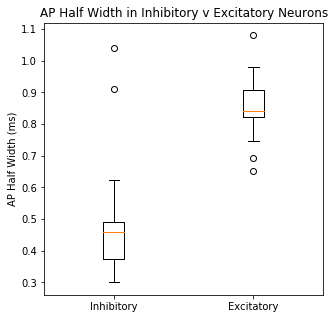

In [31]:
fig,ax = plt.subplots(figsize=(5,5))

inhib_spike_width = inhib_ephys_df['spike_width']
excit_spike_width = excit_ephys_df['spike_width']
data = [inhib_spike_width, excit_spike_width]

plt.boxplot(data)
ax.set_xticklabels(['Inhibitory', 'Excitatory'])
ax.set_ylabel('AP Half Width (ms)')
ax.set_title("AP Half Width in Inhibitory v Excitatory Neurons")

Our box plot shows that the AP half width for excitatory neurons tends to be higher than for inhibitory neurons. Though the bulk of the data points do not overlap between the two, there are some outliers that do. This could be why the zscore difference between excitatory and inhibitory AP half width is so low.

In [32]:
# import all packages needed to 
import pandas as pd

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [33]:
rna_seq_df = pd.read_csv('medians.csv',sep=',')
rna_seq_df

#The first row lists the cluster name (cluster_label), which matches the cell type alias shown in the Transcriptomic Explorer.
#The first column lists the unique gene identifier (gene), which in most cases is the gene symbol.

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_2,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,0.000000,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,0.313972,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45763,n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45764,n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45765,n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45766,n-R5s146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [34]:
rna_seq_columns = list(rna_seq_df.columns)

TODO: explain more why we picked these genes/ how we picked these genes

The genes we picked are all involved in axonal outgrowth, which contributres both to the length and the surface area of the cells.

In [35]:
# make a list of genes containing Sema, Dbn, Ulk, and Cdkl
selected_genes = []

for gene in rna_seq_df['Unnamed: 0']:
    if 'Sema' in gene:
        selected_genes.append(gene)
    elif 'Dbn' in gene:
        selected_genes.append(gene)
    elif 'Ulk' in gene:
        selected_genes.append(gene)
    elif 'Cdkl' in gene:
        selected_genes.append(gene)     

print(selected_genes)
print(len(selected_genes))

['Cdkl1', 'Cdkl2', 'Cdkl3', 'Cdkl4', 'Cdkl5', 'Dbn1', 'Dbndd1', 'Dbndd2', 'Dbnl', 'Sema3a', 'Sema3b', 'Sema3c', 'Sema3d', 'Sema3e', 'Sema3f', 'Sema3g', 'Sema4a', 'Sema4b', 'Sema4c', 'Sema4d', 'Sema4f', 'Sema4g', 'Sema5a', 'Sema5b', 'Sema6a', 'Sema6b', 'Sema6c', 'Sema6d', 'Sema7a', 'Ulk1', 'Ulk2', 'Ulk3', 'Ulk4']
33


In [36]:
# helper method to keep certain genes in the dataframe
def has_sel_genes(string):
    '''
    returns True if the row is one of the selected genes
    '''
    if string in selected_genes:
        return True
    else:
        return False

In [37]:
# makes a new columns 'selected' of T/F values depending
# on if value of the row in 'Unnamed: 0' is == a name in the list of selected genes
rna_seq_df['selected'] = rna_seq_df['Unnamed: 0'].apply(has_sel_genes)
rna_seq_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0,False
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0,False
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False


In [38]:
# keep all the rows that have the selected genes
rna_seq_sel_df = rna_seq_df[rna_seq_df['selected'] == True]
rna_seq_sel_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
4982,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4983,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4984,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,1.424641,0.0,0.0,0.0,0.588994,1.511518,0.733835,0.0,0.816241,True
4985,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True
4986,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,True


Take first 93 columns - those are all the GABAergic cells according to https://celltypes.brain-map.org/rnaseq/mouse/cortex-and-hippocampus. GABAergic are inhibitory

In [39]:
gaba_cells = rna_seq_columns[:92]
# use reset_index to make it easier to iterate over the rows in a for loop
# using reset_index makes a new column 'index' containing the old indexes -- we get rid of this column using .drop()
inhib_df = rna_seq_sel_df[gaba_cells].reset_index().drop(columns = 'index')
inhib_df.head()

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,Pvalb_6,Pvalb_7,Pvalb_8,Pvalb_9,Pvalb_10,Pvalb_11,Pvalb_12,PIR Six3,Meis2_1,Meis2_2
0,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.791623,0.000000,0.000000,0.000000,0.0
1,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,3.916947,2.562382,3.496243,4.322920,4.198744,4.739886,4.416626,0.000000,0.000000,0.0
2,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,4.590873,4.538678,4.529392,4.727894,2.316425,4.583128,4.790623,1.056769,0.000000,0.0
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,5.393745,5.927515,5.977744,6.103331,5.774603,6.552572,7.252677,2.702816,2.117104,0.0


Take first 93-271 columns - those are all the glutamatergic cells

In [40]:
glut_cells_noname = rna_seq_columns[93:271]
glut_cells = ['Unnamed: 0'] + glut_cells_noname
# add column with names of gene
excit_df = rna_seq_sel_df[glut_cells].reset_index().drop(columns = 'index')
excit_df.head()

,Unnamed: 0,DG_1,DG_2,DG_3,RSP/ACA L4/5 IT_1,L2/3 IT Cxcl14_1,L2/3 IT Cxcl14_2,L2/3 IT Cxcl14_3,L2/3 IT Cxcl14_4,L2/3 IT Cxcl14_5,...,CA1sp_9,CA1sp_10,CA3sp_1,CA3sp_2,CA3sp_3,CA3sp_4,CA3sp_5,CA3sp_6,CA3sp_7,CA2sp/IG
0,Cdkl1,0.000000,0.000000,3.746670,5.012364,0.000000,4.937156,0.000000,1.373728,0.000000,...,3.418546,0.000000,0.000000,3.152502,1.448265,3.306766,0.000000,1.635995,2.703161,0.666196
1,Cdkl2,0.000000,0.000000,5.334057,5.109621,0.000000,4.357947,1.491599,0.000000,0.738046,...,5.878004,5.902738,5.722776,5.855889,5.718631,5.807811,5.058910,5.547935,6.077206,6.415570
2,Cdkl3,0.000000,1.423622,4.252210,2.447258,0.000000,0.000000,1.437999,0.000000,0.000000,...,3.582957,1.531994,0.000000,4.175457,3.534324,4.917072,2.853081,3.655033,3.542703,3.838813
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,4.015409,2.661053,0.000000,0.000000,...,3.675164,0.000000,0.000000,0.000000,0.000000,1.987449,0.000000,0.000000,0.000000,0.000000
4,Cdkl5,6.612175,4.636283,6.266611,8.374862,6.184964,6.972876,7.048049,7.068609,7.234053,...,5.895390,6.953117,5.812516,5.823663,6.139273,6.860827,7.063832,6.579482,5.833041,7.591199


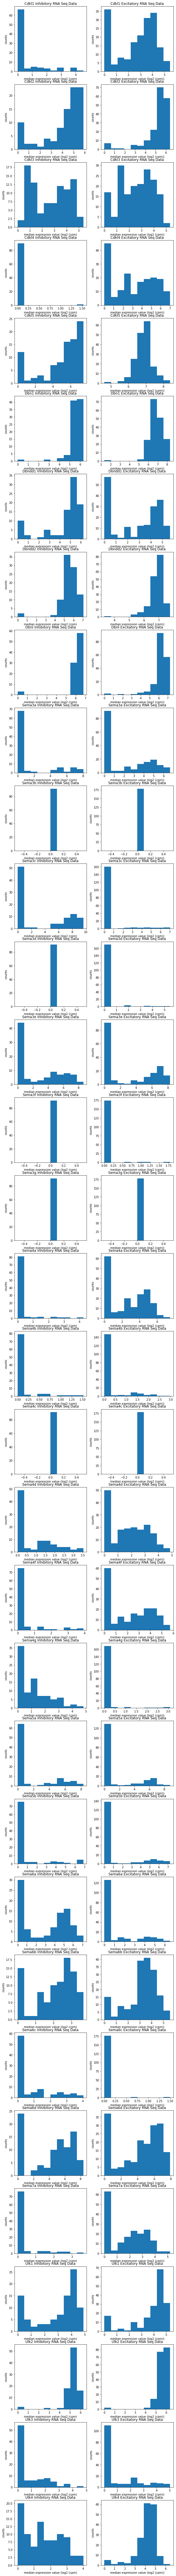

In [41]:
# exploratory analysis checking distributions of inhib and excitatory for each gene
# TODO: ylabel
num_genes = len(inhib_df)
fig, ax = plt.subplots(num_genes, 2, figsize=(10, 165))

for i in range(num_genes):
    # plot inhibitory data on left
    ax[i,0].hist(inhib_df.iloc[i][1:])
    ax[i,0].set_xlabel('median expression value (log2 (cpm)')
    ax[i,0].set_ylabel('counts')
    ax[i,0].set_title(inhib_df.loc[i][0] + ' Inhibitory RNA Seq Data')

    # plot excitatory data on right
    ax[i,1].hist(excit_df.iloc[i][1:])
    ax[i,1].set_xlabel('median expression value (log2 (cpm))')
    ax[i,1].set_ylabel('counts')
    ax[i,1].set_title(excit_df.loc[i][0] + ' Excitatory RNA Seq Data')

plt.show()

Looking at the distributions, we see that there are some genes with only 0.0 values. Since you cannot compare the same values in Mann-Whitney test, we get rid of those genes.

In [42]:
# get rid of the genes with 0.0 from the selected_genes list
removing = ['Sema3b', 'Sema3g', 'Sema4c']
for i in removing:
    selected_genes.remove(i)
    print(i)
    
print(selected_genes)

Sema3b
Sema3g
Sema4c
['Cdkl1', 'Cdkl2', 'Cdkl3', 'Cdkl4', 'Cdkl5', 'Dbn1', 'Dbndd1', 'Dbndd2', 'Dbnl', 'Sema3a', 'Sema3c', 'Sema3d', 'Sema3e', 'Sema3f', 'Sema4a', 'Sema4b', 'Sema4d', 'Sema4f', 'Sema4g', 'Sema5a', 'Sema5b', 'Sema6a', 'Sema6b', 'Sema6c', 'Sema6d', 'Sema7a', 'Ulk1', 'Ulk2', 'Ulk3', 'Ulk4']


In [43]:
# keep all the rows that do not have the genes with only '0.0' values in inhib_df and excit_df
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema3b']
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema3g']
inhib_df = inhib_df[inhib_df['Unnamed: 0'] != 'Sema4c'].reset_index().drop(columns='index')

excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema3b']
excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema3g']
excit_df = excit_df[excit_df['Unnamed: 0'] != 'Sema4c'].reset_index().drop(columns='index')

# update num_genes
num_genes = len(inhib_df)

After plotting the distributions of the genes for inhibitory neurons and exictatory neurons, we saw that almost all the populations are skewed. Therefore, we chose to run a Mann-Whitney test to compare the samples.

In [44]:
def manwhit_stats(index_of_gene):
    '''
    returns ttest results of exitatory df and inhib df of a gene at a specific index
    inputs: index number of gene
    '''
    return stats.mannwhitneyu(excit_df.iloc[index_of_gene][1:], inhib_df.iloc[index_of_gene][1:])   

In [45]:
mannwhit_results = dict()

for i in range(len(inhib_df)):
    gene_name = inhib_df['Unnamed: 0'][i]
    result_stats = manwhit_stats(i)
    mannwhit_results[gene_name] = result_stats

mannwhit_results

{'Cdkl1': MannwhitneyuResult(statistic=2872.0, pvalue=2.893544265740725e-19),
 'Cdkl2': MannwhitneyuResult(statistic=3786.0, pvalue=4.530937547843308e-13),
 'Cdkl3': MannwhitneyuResult(statistic=7813.0, pvalue=0.3181068479341936),
 'Cdkl4': MannwhitneyuResult(statistic=1988.0, pvalue=1.8158797466054293e-27),
 'Cdkl5': MannwhitneyuResult(statistic=3483.0, pvalue=1.0392446096614585e-14),
 'Dbn1': MannwhitneyuResult(statistic=769.0, pvalue=3.204189887081746e-34),
 'Dbndd1': MannwhitneyuResult(statistic=3504.0, pvalue=8.777553037750055e-15),
 'Dbndd2': MannwhitneyuResult(statistic=1053.0, pvalue=9.016674348694804e-32),
 'Dbnl': MannwhitneyuResult(statistic=6365.0, pvalue=0.002042882886585207),
 'Sema3a': MannwhitneyuResult(statistic=6527.0, pvalue=0.0018576779876655952),
 'Sema3c': MannwhitneyuResult(statistic=4990.0, pvalue=5.73477230947168e-13),
 'Sema3d': MannwhitneyuResult(statistic=7689.5, pvalue=0.014826313294100012),
 'Sema3e': MannwhitneyuResult(statistic=7857.0, pvalue=0.337396090

In [46]:
# highlight values that are below 0.05 (significance level)

for i in mannwhit_results.keys():
    pval = mannwhit_results[i][1]
    if pval < 0.05:
        print(i+ '; pval: '+str(pval))

Cdkl1; pval: 2.893544265740725e-19
Cdkl2; pval: 4.530937547843308e-13
Cdkl4; pval: 1.8158797466054293e-27
Cdkl5; pval: 1.0392446096614585e-14
Dbn1; pval: 3.204189887081746e-34
Dbndd1; pval: 8.777553037750055e-15
Dbndd2; pval: 9.016674348694804e-32
Dbnl; pval: 0.002042882886585207
Sema3a; pval: 0.0018576779876655952
Sema3c; pval: 5.73477230947168e-13
Sema3d; pval: 0.014826313294100012
Sema4a; pval: 6.307870729219536e-19
Sema4d; pval: 7.895128982162661e-08
Sema4f; pval: 6.294031254946503e-17
Sema4g; pval: 1.0359738105519828e-23
Sema6a; pval: 1.804868564200393e-11
Sema6b; pval: 2.8991727607335664e-14
Sema6c; pval: 2.512988968180287e-16
Sema7a; pval: 4.960811374659922e-15
Ulk1; pval: 9.411425445432194e-08
Ulk2; pval: 1.1560342768192409e-12
Ulk4; pval: 2.8046705437408185e-33


In the above listed genes with a significance level of 0.05, we found a significant difference in gene expression between inhibitory and excitatory neurons.

30


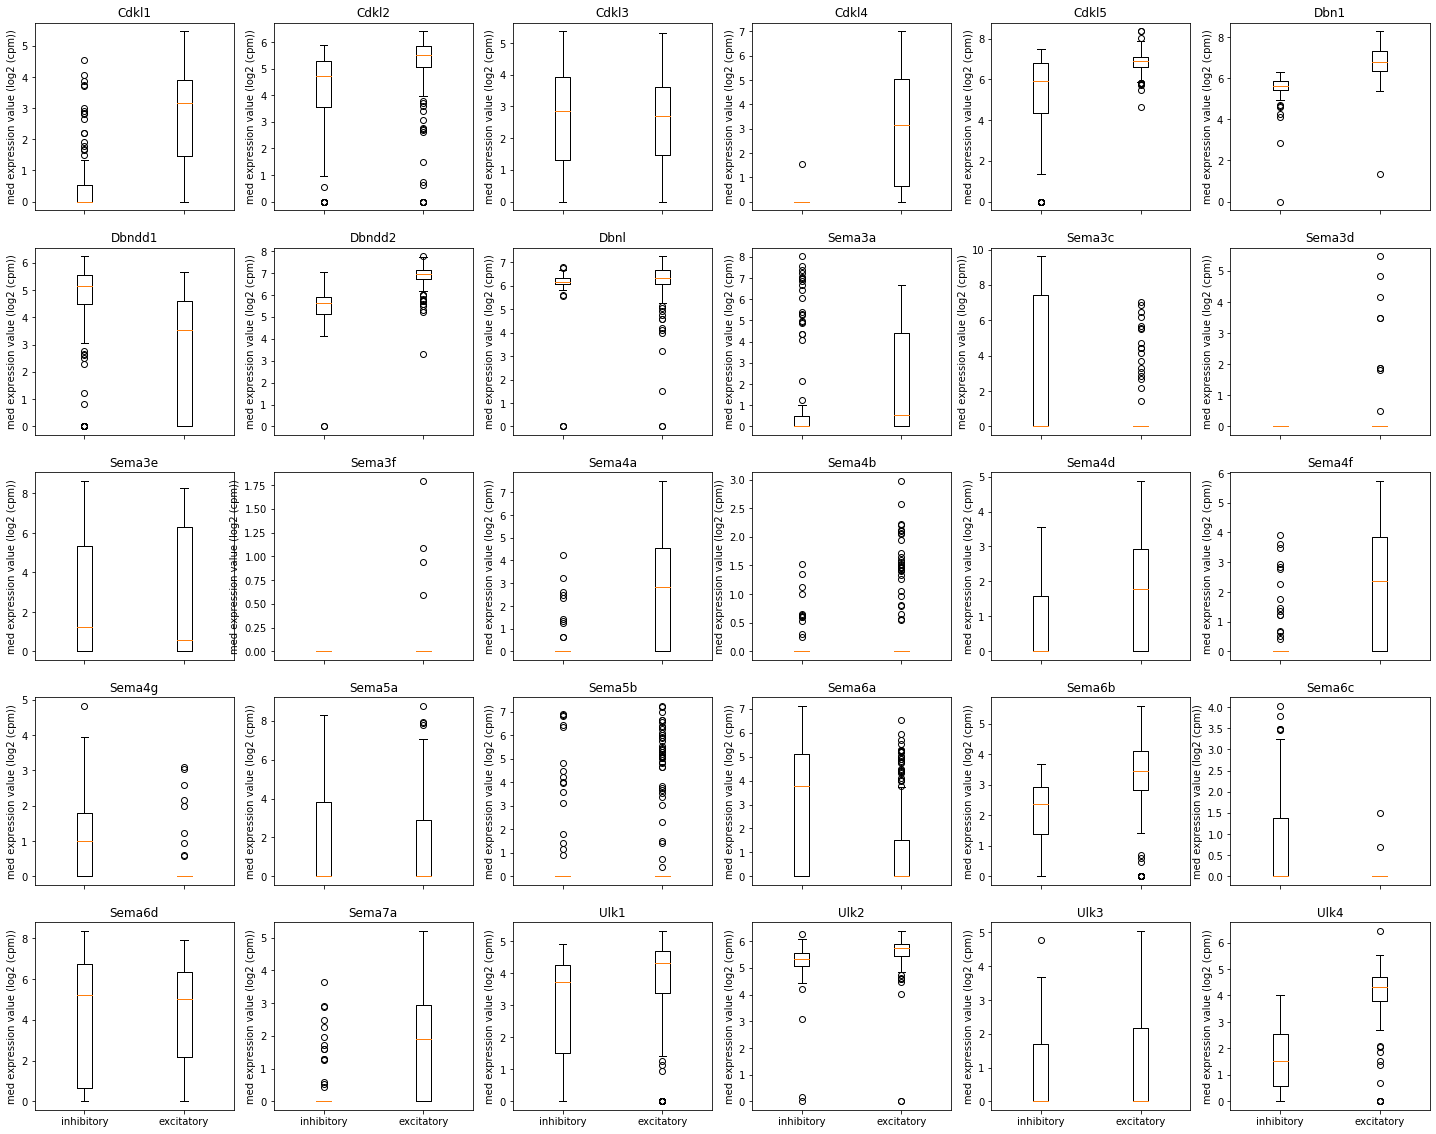

In [47]:
figures_across = 6
fig, ax = plt.subplots(5, figures_across, figsize=(25,20),sharex=True)
y_label = 'med expression value (log2 (cpm))'
print(num_genes)

for i in range(num_genes):
    if i < figures_across:
        x_val = 0
        y_val = i
        
    elif i < (2*figures_across):
        x_val = 1
        y_val = i - (figures_across)
    
    elif i < (3*figures_across):
        x_val = 2
        y_val = i - (2*figures_across)
        
    elif i < (4*figures_across):
        x_val = 3
        y_val = i - (3*figures_across)
    
    elif i <= (5*figures_across):
        x_val = 4
        y_val = i - (4*figures_across)
    
    elif i == (6*figures_across):
        x_val = 4
        y_val = 5
    
    ax[x_val,y_val].boxplot(([inhib_df.loc[i][1:], excit_df.loc[i][1:]]))
    ax[x_val,y_val].set_title(inhib_df.loc[i][0])
    ax[x_val,y_val].set_ylabel(y_label)
    
plt.xticks([1,2],['inhibitory','excitatory'])
plt.show()

In [57]:
# make list of gene families containing genes potentially related to ephys
ephys_genes = []
scn = []
chrn =[]
kcn = []
cacn = []


for gene in rna_seq_df['Unnamed: 0']:
    if 'Scn' in gene:
        # select only gene 'a' to narrow down what we have to look at (with this, now we look at 36 genes)
        if (gene[-1] == 'a'):
            ephys_genes.append(gene)
            scn.append(gene)
    elif 'Chrn' in gene:
        if (gene[-1] == '1'):
            ephys_genes.append(gene)
            chrn.append(gene)
    elif 'Kcn' in gene:
        if (gene[-1] == '1'):
            ephys_genes.append(gene)
            kcn.append(gene)
    elif 'Cacn' in gene:
        if (gene[-1] == 'a'):
            ephys_genes.append(gene)   
            cacn.append(gene)

print(ephys_genes)
print(len(ephys_genes))

print(len(scn))
print(len(chrn))
print(len(kcn))
print(len(cacn))

['Cacna1a', 'Chrna1', 'Chrnb1', 'Kcna1', 'Kcnab1', 'Kcnb1', 'Kcnc1', 'Kcnd1', 'Kcne1', 'Kcnf1', 'Kcng1', 'Kcnh1', 'Kcnip1', 'Kcnj1', 'Kcnj11', 'Kcnk1', 'Kcnma1', 'Kcnmb1', 'Kcnmb4os1', 'Kcnn1', 'Kcnq1', 'Kcnq1ot1', 'Kcns1', 'Kcnt1', 'Kcnu1', 'Kcnv1', 'Scn10a', 'Scn11a', 'Scn1a', 'Scn3a', 'Scn4a', 'Scn5a', 'Scn7a', 'Scn8a', 'Scn9a', 'Scnn1a']
36
10
2
23
1


In [48]:
# helper method to keep certain genes in the dataframe
def has_ephys_genes(string):
    '''
    returns True if the row is one of the selected genes
    '''
    if string in ephys_genes:
        return True
    else:
        return False

In [50]:
# makes a new columns 'selected' of T/F values depending
# on if value of the row in 'Unnamed: 0' is == a name in the list of selected genes
rna_seq_df['selected'] = rna_seq_df['Unnamed: 0'].apply(has_ephys_genes)

# keep all the rows that have the selected genes
rna_seq_sel_df = rna_seq_df[rna_seq_df['selected'] == True]
rna_seq_sel_df

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
4319,Cacna1a,5.894857,5.520003,5.569040,5.558331,5.818982,5.181436,5.848839,5.404175,4.822660,...,4.255161,0.000000,1.023332,1.090622,0.000000,0.00000,0.000000,0.000000,0.000000,True
5269,Chrna1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
5278,Chrnb1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
25434,Kcna1,5.189126,5.765560,4.835621,4.907346,6.304769,5.389732,6.447069,5.696954,5.009771,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
25442,Kcnab1,5.517135,7.238046,7.150560,6.920153,6.352956,7.271900,6.646063,6.207012,7.029335,...,0.642925,0.000000,0.000000,0.000000,0.000000,0.00000,9.652507,0.000000,0.000000,True
25445,Kcnb1,5.728715,5.859688,5.902831,5.588138,5.303227,4.668982,5.561774,5.369779,4.485670,...,0.644327,0.000000,1.233956,0.000000,0.000000,0.00000,1.246142,0.000000,0.000000,True
25447,Kcnc1,6.996059,5.881594,5.792314,6.491154,7.477354,6.310203,7.061105,6.683021,6.383297,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
25451,Kcnd1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
25455,Kcne1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True
25460,Kcnf1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,True


In [52]:
gaba_cells = rna_seq_columns[:92]
# use reset_index to make it easier to iterate over the rows in a for loop
# using reset_index makes a new column 'index' containing the old indexes -- we get rid of this column using .drop()
inhib_df = rna_seq_sel_df[gaba_cells].reset_index().drop(columns = 'index')

glut_cells_noname = rna_seq_columns[93:271]
glut_cells = ['Unnamed: 0'] + glut_cells_noname
# add column with names of gene
excit_df = rna_seq_sel_df[glut_cells].reset_index().drop(columns = 'index')

print(inhib_df.shape)
print(excit_df.shape)

(36, 92)
(36, 179)


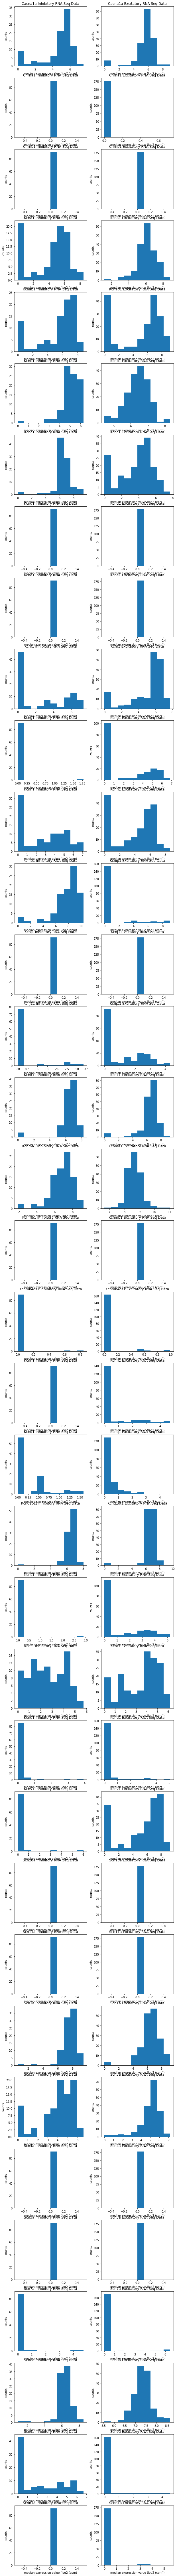

In [53]:
# exploratory analysis checking distributions of inhib and excitatory for each gene
# TODO: ylabel
num_genes = len(inhib_df)
fig, ax = plt.subplots(num_genes, 2, figsize=(10, 165))

for i in range(num_genes):
    # plot inhibitory data on left
    ax[i,0].hist(inhib_df.iloc[i][1:])
    ax[i,0].set_xlabel('median expression value (log2 (cpm)')
    ax[i,0].set_ylabel('counts')
    ax[i,0].set_title(inhib_df.loc[i][0] + ' Inhibitory RNA Seq Data')

    # plot excitatory data on right
    ax[i,1].hist(excit_df.iloc[i][1:])
    ax[i,1].set_xlabel('median expression value (log2 (cpm))')
    ax[i,1].set_ylabel('counts')
    ax[i,1].set_title(excit_df.loc[i][0] + ' Excitatory RNA Seq Data')

plt.show()

In [58]:
# get rid of the genes with only 0.0s from the ephys_genes list
removing = ['Chrna1', 'Chrnb1', 'Kcnd1', 'Kcne1', 'Kcnj1','Kcnmb1','Scn10a', 'Scn11a','Scn4a','Scn5a']
for i in removing:
    ephys_genes.remove(i)
    print(i)
    
print(ephys_genes)

Chrna1
Chrnb1
Kcnd1
Kcne1
Kcnj1
Kcnmb1
Scn10a
Scn11a
Scn4a
Scn5a
['Cacna1a', 'Kcna1', 'Kcnab1', 'Kcnb1', 'Kcnc1', 'Kcnf1', 'Kcng1', 'Kcnh1', 'Kcnip1', 'Kcnj11', 'Kcnk1', 'Kcnma1', 'Kcnmb4os1', 'Kcnn1', 'Kcnq1', 'Kcnq1ot1', 'Kcns1', 'Kcnt1', 'Kcnu1', 'Kcnv1', 'Scn1a', 'Scn3a', 'Scn7a', 'Scn8a', 'Scn9a', 'Scnn1a']


In [59]:
# keep all the rows that do not have the genes with only '0.0' values in inhib_df and excit_df

for i in removing:
    inhib_df = inhib_df[inhib_df['Unnamed: 0'] != i].reset_index().drop(columns='index')
    excit_df = excit_df[excit_df['Unnamed: 0'] != i].reset_index().drop(columns='index')

In [61]:
# update num_genes
num_genes = len(inhib_df)

In [62]:
mannwhit_ephys_results = dict()

for i in range(len(inhib_df)):
    gene_name = inhib_df['Unnamed: 0'][i]
    result_stats = manwhit_stats(i)
    mannwhit_ephys_results[gene_name] = result_stats

mannwhit_ephys_results

{'Cacna1a': MannwhitneyuResult(statistic=4625.0, pvalue=4.350633794655412e-09),
 'Kcna1': MannwhitneyuResult(statistic=4091.0, pvalue=1.5705972470139806e-11),
 'Kcnab1': MannwhitneyuResult(statistic=7594.0, pvalue=0.2005435665506809),
 'Kcnb1': MannwhitneyuResult(statistic=1364.0, pvalue=3.371153192655872e-29),
 'Kcnc1': MannwhitneyuResult(statistic=1178.0, pvalue=9.264775108853186e-31),
 'Kcnf1': MannwhitneyuResult(statistic=3872.0, pvalue=9.324649972128031e-13),
 'Kcng1': MannwhitneyuResult(statistic=4602.0, pvalue=3.0789626917528307e-13),
 'Kcnh1': MannwhitneyuResult(statistic=5795.0, pvalue=5.913309536576774e-05),
 'Kcnip1': MannwhitneyuResult(statistic=690.0, pvalue=6.881964201704476e-43),
 'Kcnj11': MannwhitneyuResult(statistic=5442.0, pvalue=2.2661474124910229e-07),
 'Kcnk1': MannwhitneyuResult(statistic=7887.0, pvalue=0.36304103676543575),
 'Kcnma1': MannwhitneyuResult(statistic=779.0, pvalue=3.922691157385593e-34),
 'Kcnmb4os1': MannwhitneyuResult(statistic=7647.0, pvalue=0.03

In [64]:
# highlight values that are below 0.05 (significance level)

for i in mannwhit_ephys_results.keys():
    pval = mannwhit_ephys_results[i][1]
    if pval < 0.05:
        print(i+ '; pval: '+str(pval))

Cacna1a; pval: 4.350633794655412e-09
Kcna1; pval: 1.5705972470139806e-11
Kcnb1; pval: 3.371153192655872e-29
Kcnc1; pval: 9.264775108853186e-31
Kcnf1; pval: 9.324649972128031e-13
Kcng1; pval: 3.0789626917528307e-13
Kcnh1; pval: 5.913309536576774e-05
Kcnip1; pval: 6.881964201704476e-43
Kcnj11; pval: 2.2661474124910229e-07
Kcnma1; pval: 3.922691157385593e-34
Kcnmb4os1; pval: 0.03404165531614178
Kcnn1; pval: 1.134536387130261e-06
Kcnq1ot1; pval: 0.0020916098971441666
Kcns1; pval: 6.022426267697226e-11
Kcnt1; pval: 2.9363030109995402e-05
Kcnu1; pval: 0.011615140583533958
Kcnv1; pval: 6.443508647139977e-29
Scn1a; pval: 1.6081146519537248e-15
Scn3a; pval: 2.00872739635937e-07
Scn8a; pval: 1.1669555362488204e-28
Scn9a; pval: 2.3562540268308563e-17
Scnn1a; pval: 0.0388163204191122


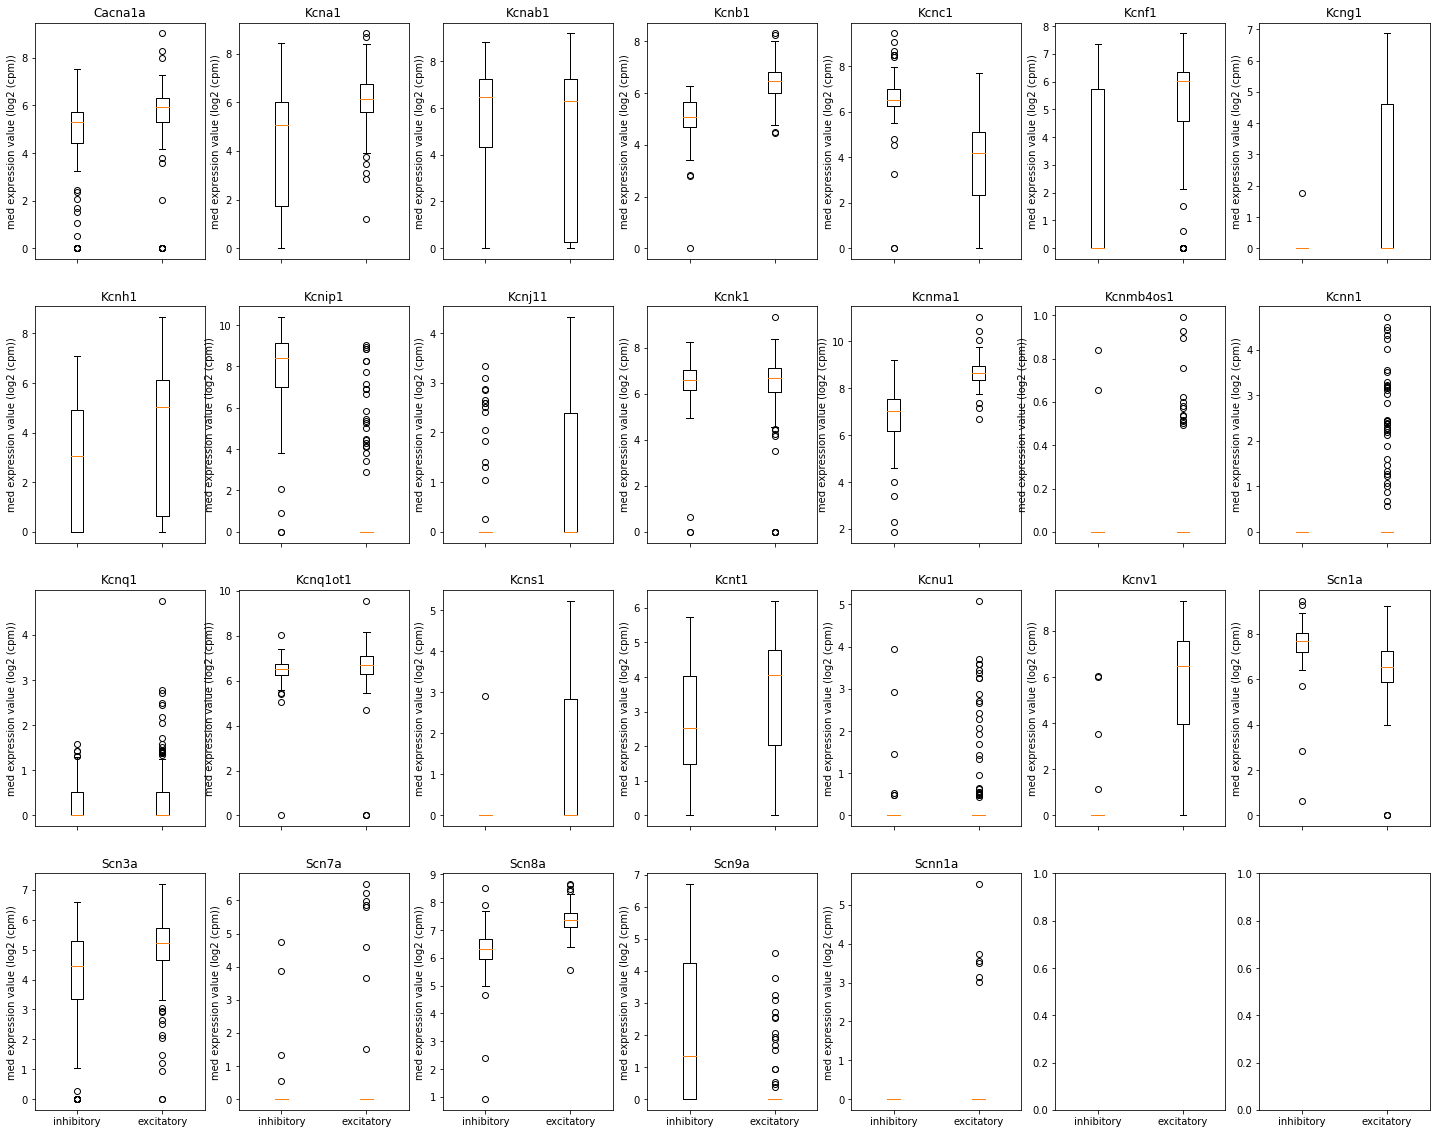

In [68]:
figures_across = 7
fig, ax = plt.subplots(4, figures_across, figsize=(25,20),sharex=True)
y_label = 'med expression value (log2 (cpm))'

for i in range(num_genes):
    if i < figures_across:
        x_val = 0
        y_val = i
        
    elif i < (2*figures_across):
        x_val = 1
        y_val = i - (figures_across)
    
    elif i < (3*figures_across):
        x_val = 2
        y_val = i - (2*figures_across)
        
    elif i < (4*figures_across):
        x_val = 3
        y_val = i - (3*figures_across)
    
    elif i <= (5*figures_across):
        x_val = 4
        y_val = i - (4*figures_across)
    
    elif i == (6*figures_across):
        x_val = 4
        y_val = 5
    
    ax[x_val,y_val].boxplot(([inhib_df.loc[i][1:], excit_df.loc[i][1:]]))
    ax[x_val,y_val].set_title(inhib_df.loc[i][0])
    ax[x_val,y_val].set_ylabel(y_label)
    
plt.xticks([1,2],['inhibitory','excitatory'])
plt.show()

# III. Conclusion & Discussion:

## Additional References (not previously mentioned in Background and Prior Work):

# IV. Reflection: